## Регуляризация
#### Применить методы линейной регресии, lasso, lasso cv, ridge и ridge cv к данным и вывести MSE и коэффициенты

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Загрузка файла
#Данные представляют собой информацио о прокате велисипедов. Учитываются факторы:
#Даты, сезона, года, месяца, праздника, дня недели, рабочего/выходного, погоды, температуры, влажности, скорости ветра, 
#количество зарегистрированных и случайных (не зарегистрирванных) пользователей
#cnt - количество арендованных велосипедов
#исследуется зависимость cnt от вышезаданных факторов


In [3]:
df = pd.read_csv('day.csv', sep=',')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [5]:
#размер таблицы
df.shape

(731, 16)

In [6]:
#Визуализация данных
plt.rcParams['figure.figsize'] = (12,8)

<AxesSubplot:xlabel='season', ylabel='cnt'>

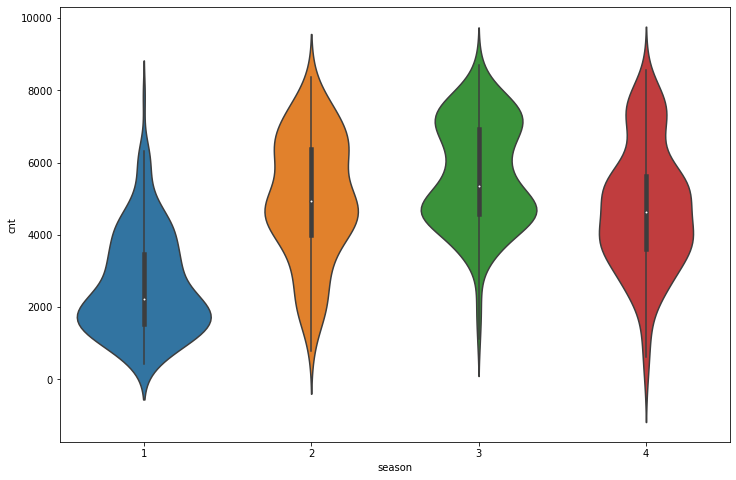

In [7]:
#зависимость количества арендованных велосипедов от сезона
#1 сезон - весна, 2 - лето, 3 - осень, 4 - зима
#весной в среднем арендовали 2000 велосипедов в день, летом - от 4000 до 8000, осенью примерно столько же, но чуть меньше, зимой -
#в среднем 4000
sns.violinplot(x=df['season'], y=df['cnt'])

<AxesSubplot:xlabel='season', ylabel='cnt'>

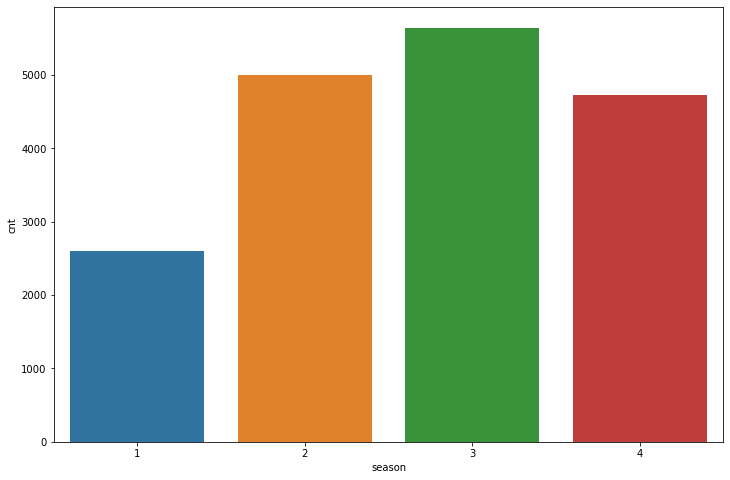

In [8]:
sns.barplot(x=df.groupby('season').mean().index, y=df.groupby('season').mean()['cnt'])

<AxesSubplot:>

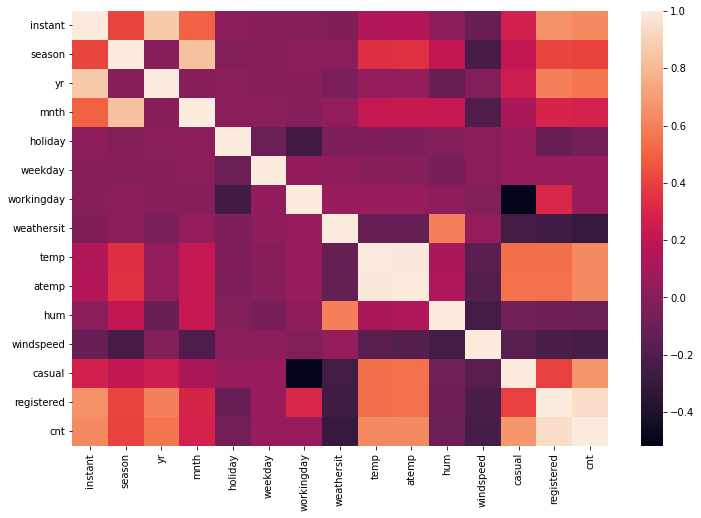

In [9]:
sns.heatmap(df.corr())

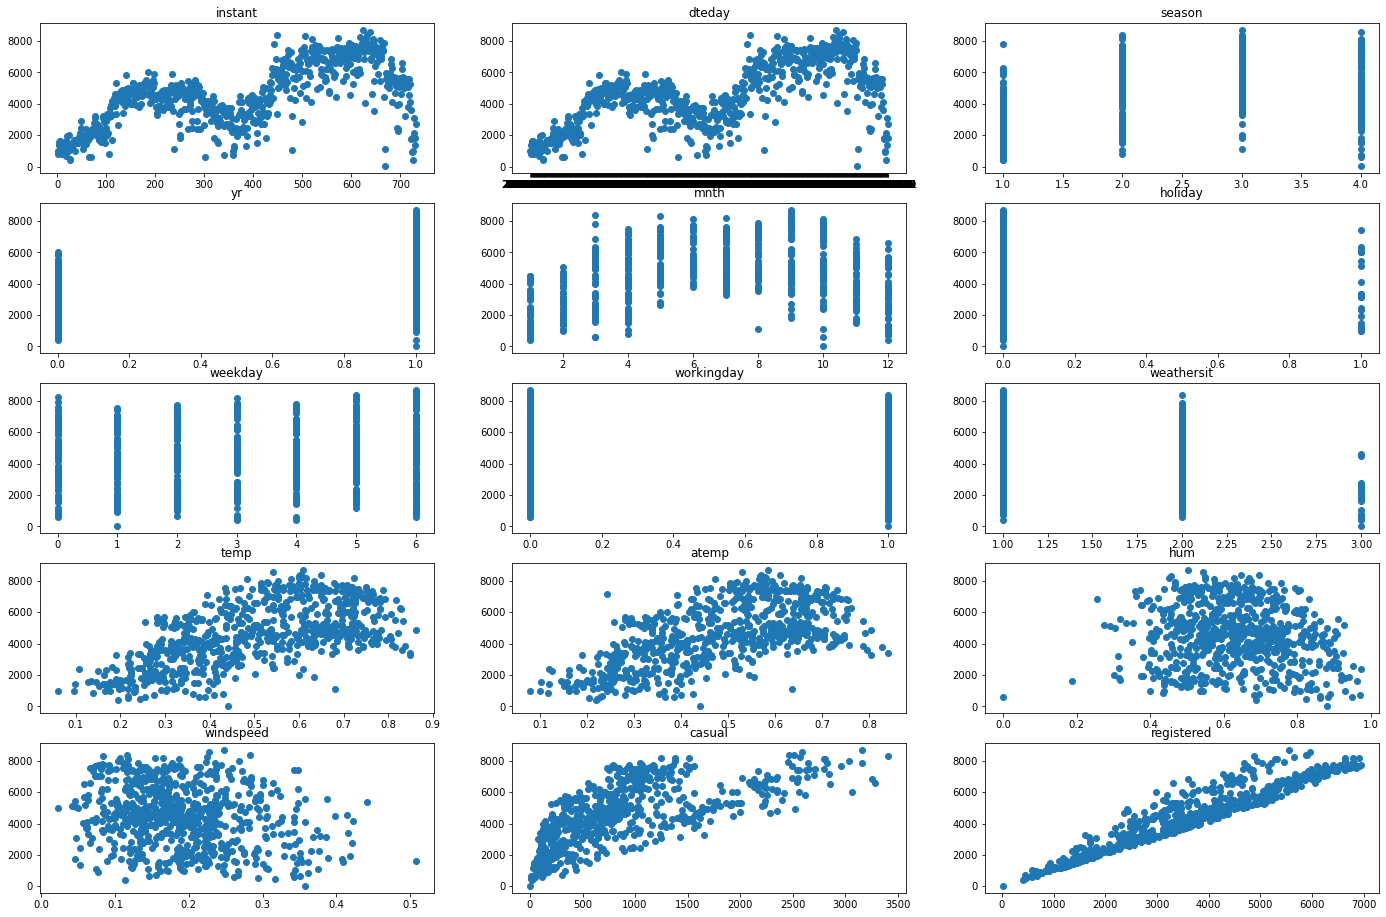

In [10]:
plt.rcParams['figure.figsize'] = (24,16)
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(5, 3, i+1)
    plt.scatter(df[col], df['cnt'])
    plt.title(col)

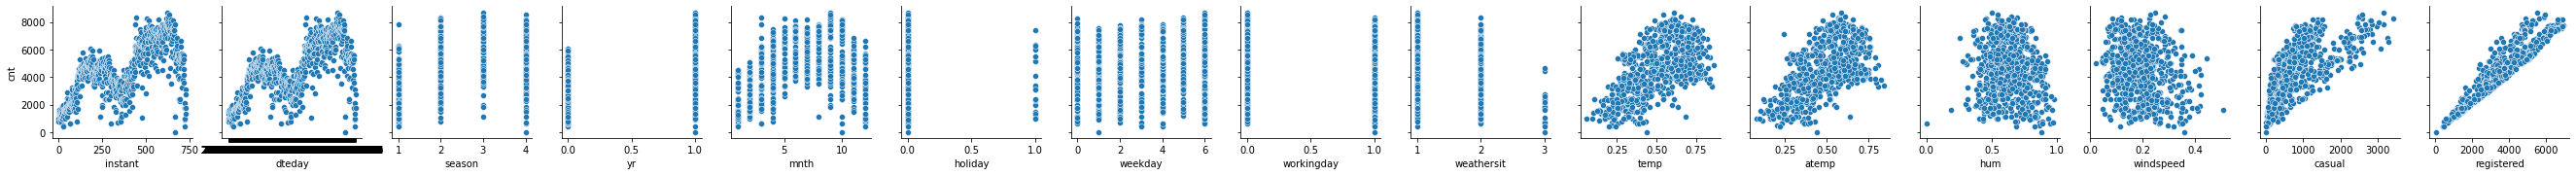

In [11]:
#Таблица рассеивания количества арендованных велосипедов от всех факторов
sns.pairplot(df, x_vars=df.columns.drop("cnt"), y_vars=["cnt"])

In [12]:
plt.rcParams['figure.figsize'] = (12,8)

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

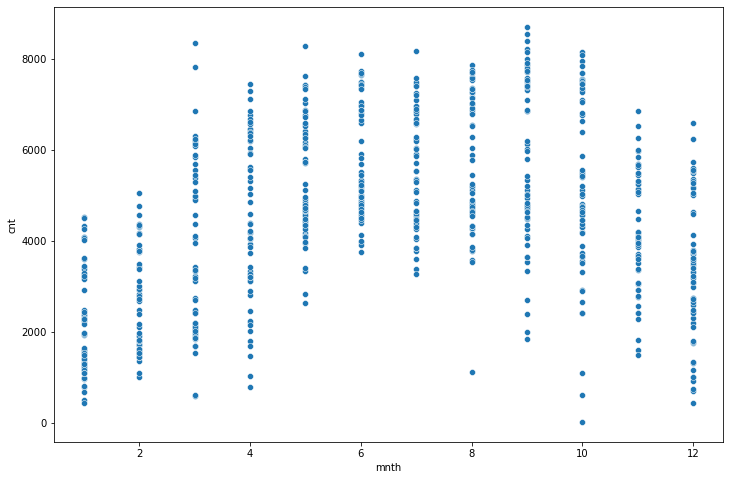

In [13]:
#отдельно рассмотрим таблицу рассеяния количества велосипедов от месяца. В среднем летом-осенью их больше всего арендуют
sns.scatterplot(x=df['mnth'],y=df['cnt'])

<AxesSubplot:xlabel='temp', ylabel='cnt'>

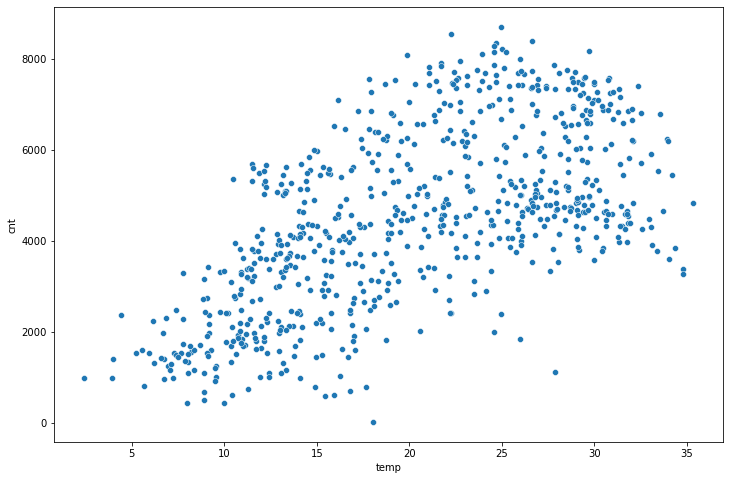

In [14]:
#Зависимость cnt от температуры воздуха (значения делятся на 41)
#вполне очевидно, что когда температура примерно 20-30 градусов (0.5-0.6), велосипеды арендуют более активнее
sns.scatterplot(x=df['temp']*41,y=df['cnt'])

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

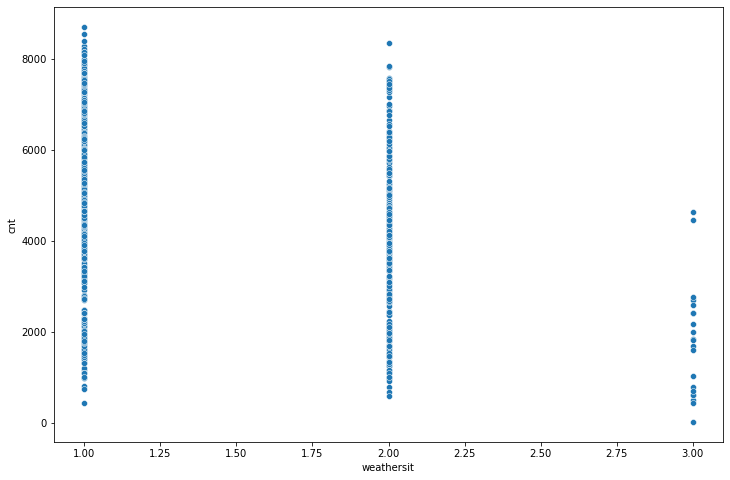

In [15]:
#Зависимость cnt от погоды
#1 - небольшая облачность
#2 - туман
#3 - легкий снег
#так же видна зависисмость что больше велосипедов арендуют в хорошую погоду. Когда идет снег, велосипеды арендуют достаточно редко
sns.scatterplot(x=df['weathersit'],y=df['cnt'])

In [16]:
#Замечание
#Визуалзация данных показывает, что некоторые столбцы в таблице не нужны. Однозначно можно убрать номер наблюдения,
#от него ничего не зависит. Дата наблюдения так же не нужна. В таблице уже есть столбцы и с днями недели и с месяцами и с годами
#Сначала исследуем зависимость cnt от всех факторов кроме этих двух, далее посмотрим, что ещё можно сделать для улучшения модели

In [17]:
df = df.drop(['instant', 'dteday'], axis=1)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [18]:
#Применить методы линейной регресии, lasso, lasso cv, ridge и ridge cv к данным и вывести MSE и коэффициенты
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [19]:
linreg = LinearRegression()
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
lasso_cv = LassoCV(random_state=42)
ridge_cv=RidgeCV()

In [20]:
#Объясняемая переменная - количество арендованных велосипедов
#Факторы - все параметры в таблице, исключая порядковый номер наблюдения и дату (у нас итак есть день, месяц, год)
y = df['cnt'].values
x = df.drop(['cnt'], axis=1).values

In [21]:
#Делим выборку на обучающую (70%) и контрольную (30%)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7)

In [22]:
#Стандартизация данных необходима, так как данные находятся в разных единицах измерения
#Лучше подходит стандартизация minmax, так как у нас много рваных данных, принимающих значения 0-1
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)

In [23]:
#функция, которая применяет выбранный метод к данным и выводит корень MSE, коэффициенты для полученной модели и график,
#показывающий отклонения реальных значений от предсказанных по обущающей выборке
def train_validate_report(model, x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names):
    model.fit(x_train_scaled, y_train)
    R = model.score(x_train_scaled, y_train)
    print(f'Ошибка: {np.sqrt(mean_squared_error(y_valid, model.predict(x_valid_scaled)))}')
    print(f'Коэффициент детерминации: {R}')
    print(pd.DataFrame(model.coef_, feature_names, columns=['coef']).sort_values(by='coef', ascending=False))
    pred = pd.DataFrame({
        'pred':model.predict(x_valid_scaled),
        'real':y_valid})
    pred.plot()


Ошибка: 384.3742016336848
Коэффициент детерминации: 1.0
                    coef
registered  6.897000e+03
casual      3.281000e+03
temp        3.963261e-12
weathersit  1.174217e-12
yr          9.777404e-13
workingday  8.941833e-13
hum         7.179100e-13
windspeed   5.354770e-13
season     -3.065591e-13
weekday    -6.961269e-13
mnth       -2.995100e-12
holiday    -3.372168e-12
atemp      -3.615456e-12


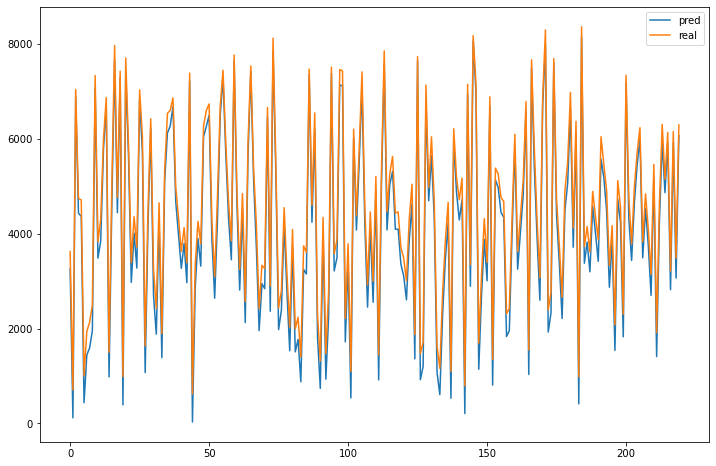

In [24]:
#Линейная регрессия
train_validate_report(linreg,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 382.47840684892424
Коэффициент детерминации: 0.9999919323121902
                   coef
registered  6882.193213
casual      3262.873455
yr             1.918657
season         0.000000
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
weathersit    -0.000000
temp           0.000000
atemp          0.000000
hum           -0.000000
windspeed     -0.000000


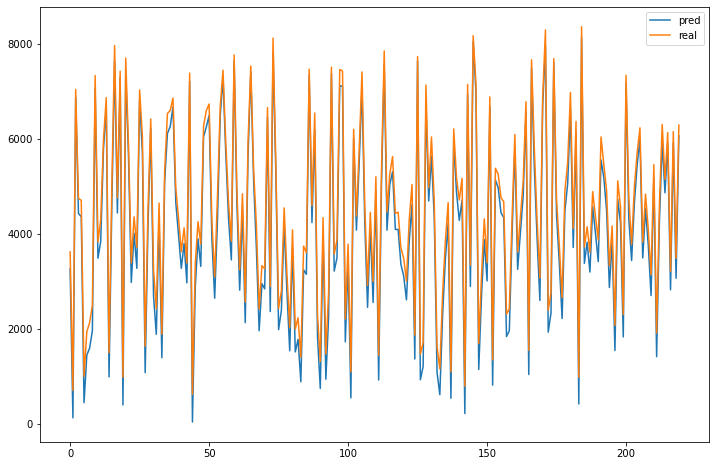

In [25]:
#Применим метод регуляризации Лассо
train_validate_report(lasso,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 383.3285284961366
Коэффициент детерминации: 0.9999975959972602
                   coef
registered  6888.898767
casual      3271.115889
yr             1.055549
season         0.000000
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
weathersit    -0.000000
temp           0.000000
atemp          0.000000
hum           -0.000000
windspeed     -0.000000


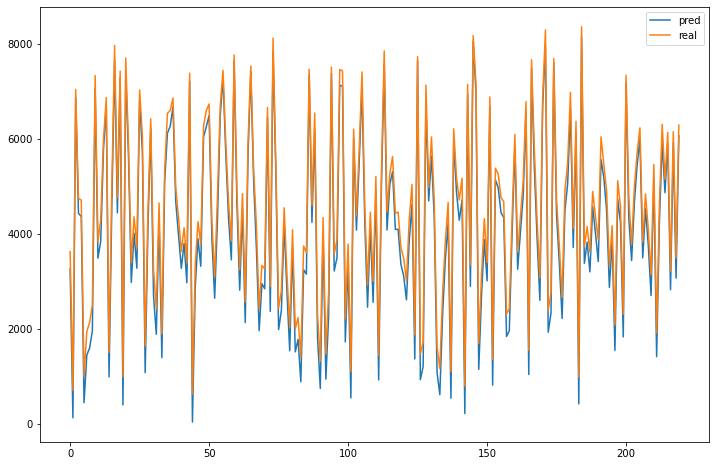

In [26]:
#Лассо CV
train_validate_report(lasso_cv,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 351.2441731375222
Коэффициент детерминации: 0.9965939107843093
                   coef
registered  5781.217204
casual      3099.864299
yr           290.791888
atemp        283.678940
season       245.705710
temp         220.038184
workingday   123.015651
weekday       54.511554
holiday      -35.276992
mnth         -59.257642
hum          -87.079238
windspeed   -135.921796
weathersit  -173.615016


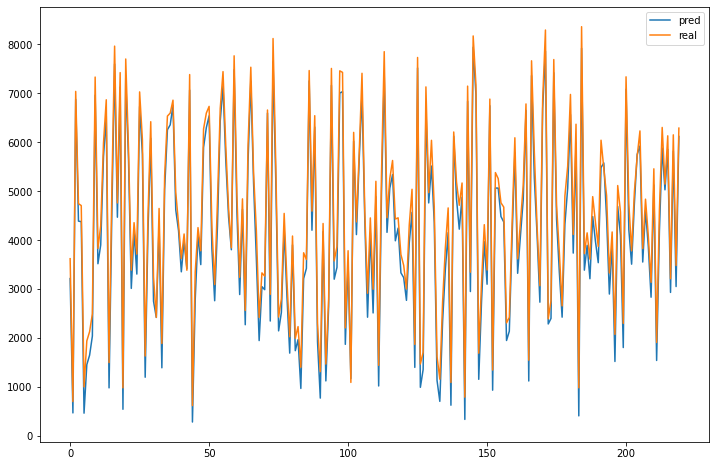

In [27]:
#Метод ridge
train_validate_report(ridge,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 378.04817114592043
Коэффициент детерминации: 0.9999495938428321
                   coef
registered  6758.243111
casual      3264.311192
atemp         56.638031
yr            35.884964
season        31.259835
workingday    16.680371
weekday        6.684532
temp           5.198211
holiday       -3.991245
mnth          -8.432296
hum          -11.273592
windspeed    -16.426773
weathersit   -20.973690


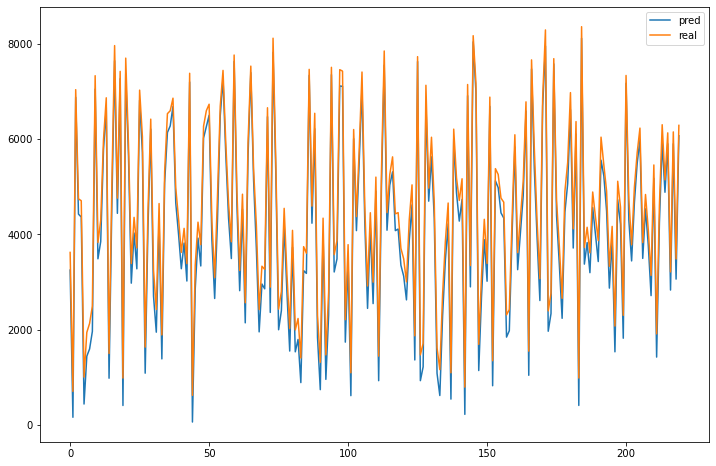

In [28]:
#Метод ridge cv
train_validate_report(ridge_cv,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

## Придумать свой способ обучения модели (удаление незначащих данных, коррелирующих значений и тд)
### Сделать визуализацию и соответствующие выводы

<AxesSubplot:>

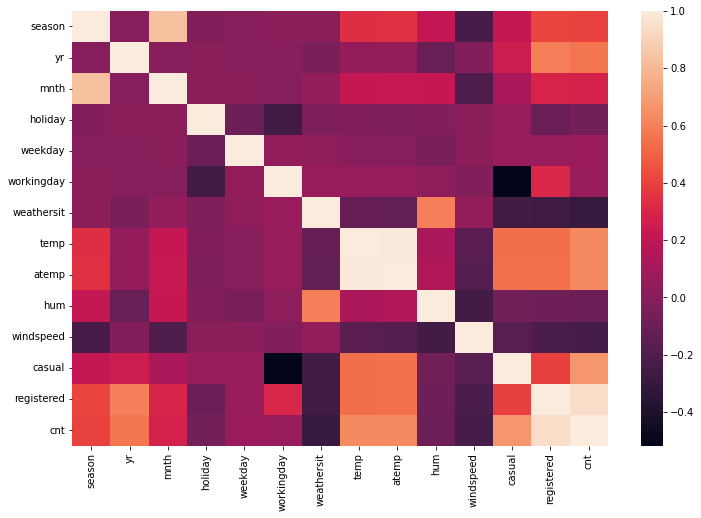

In [29]:
#Сделаем новую таблицу без weathersit (погода определяется детальнее через температуру, влажность, ветер),
#  atemp (температура тела сильно зависит от temp) и season (используем month)
sns.heatmap(df.corr())

In [30]:
#построим корреляционную матрицу и попробуем избавиться от незначащих переменных
df = df.drop(['weathersit', 'atemp', 'season'], axis=1)
df.head()

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,casual,registered,cnt
0,0,1,0,6,0,0.344167,0.805833,0.160446,331,654,985
1,0,1,0,0,0,0.363478,0.696087,0.248539,131,670,801
2,0,1,0,1,1,0.196364,0.437273,0.248309,120,1229,1349
3,0,1,0,2,1,0.200000,0.590435,0.160296,108,1454,1562
4,0,1,0,3,1,0.226957,0.436957,0.186900,82,1518,1600


<AxesSubplot:>

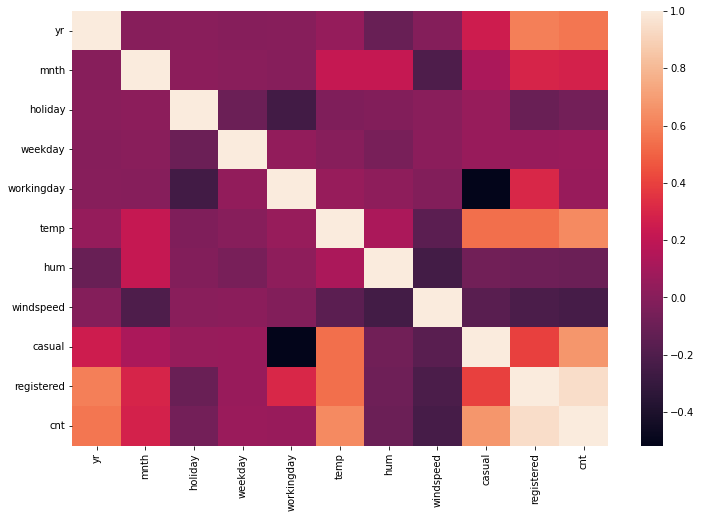

In [31]:
sns.heatmap(df.corr())

In [32]:
y = df['cnt'].values
x = df.drop(['cnt'], axis=1).values
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7)

In [33]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)

Ошибка: 263.8791654472087
Коэффициент детерминации: 1.0
                    coef
registered  6.530000e+03
casual      3.401000e+03
yr          3.542524e-12
weekday     2.230295e-12
hum         2.195572e-12
workingday  2.068121e-12
windspeed   3.965444e-13
temp       -9.037392e-15
holiday    -1.158902e-12
mnth       -3.189353e-12


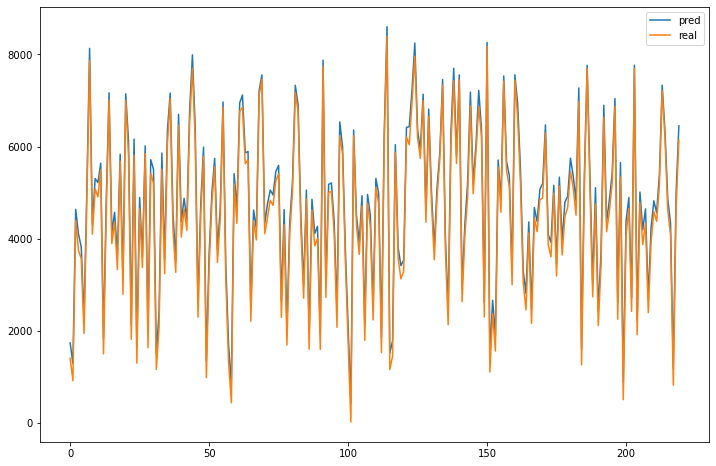

In [34]:
#Линейная регрессия
train_validate_report(linreg,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 263.4174610735196
Коэффициент детерминации: 0.99999231286757
                   coef
registered  6518.086939
casual      3380.893572
yr             1.711316
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
temp           0.000000
hum           -0.000000
windspeed     -0.000000


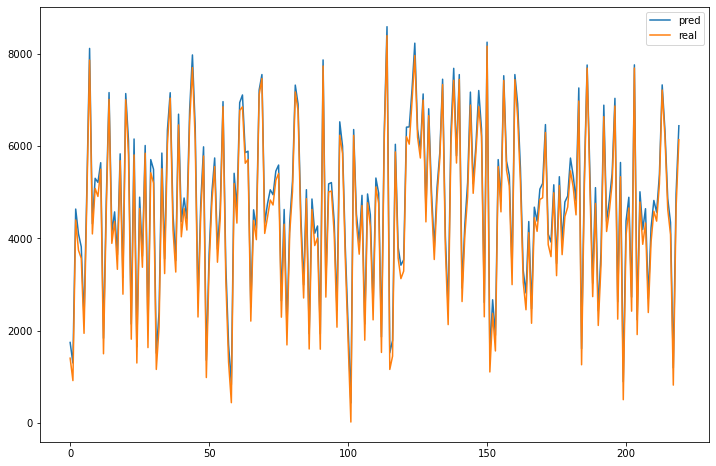

In [35]:
#Лассо
train_validate_report(lasso,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 263.59950185986713
Коэффициент детерминации: 0.9999974542777882
                   coef
registered  6523.064733
casual      3389.474565
yr             1.020128
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
temp           0.000000
hum           -0.000000
windspeed     -0.000000


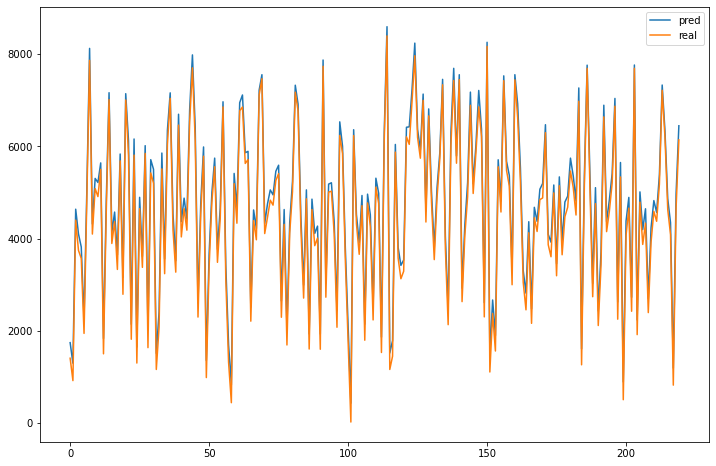

In [37]:
#Лассо CV
train_validate_report(lasso_cv,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 287.8681035402788
Коэффициент детерминации: 0.9976602240428248
                   coef
registered  5740.313548
casual      3243.940174
temp         441.680989
yr           225.286171
mnth         131.870893
workingday    89.480270
weekday       20.564572
holiday      -58.869843
windspeed   -145.701609
hum         -212.338963


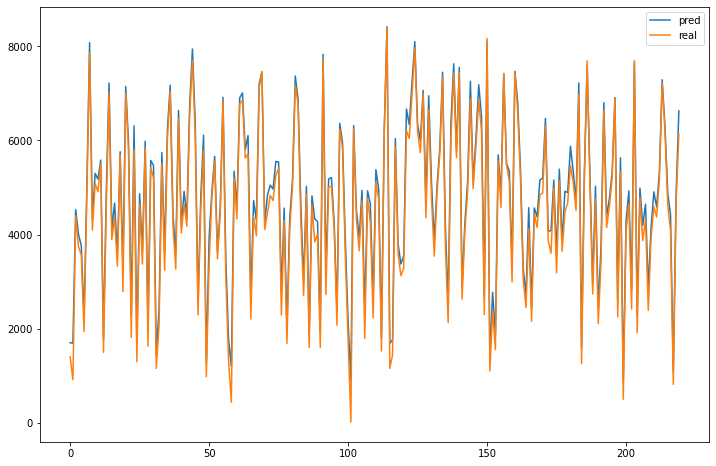

In [38]:
#Метод ridge
train_validate_report(ridge,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 265.0640878760658
Коэффициент детерминации: 0.9999670334740017
                   coef
registered  6434.518575
casual      3385.303393
temp          53.564588
yr            27.005115
mnth          16.062267
workingday    11.555937
weekday        2.349293
holiday       -7.367559
windspeed    -18.179928
hum          -27.705100


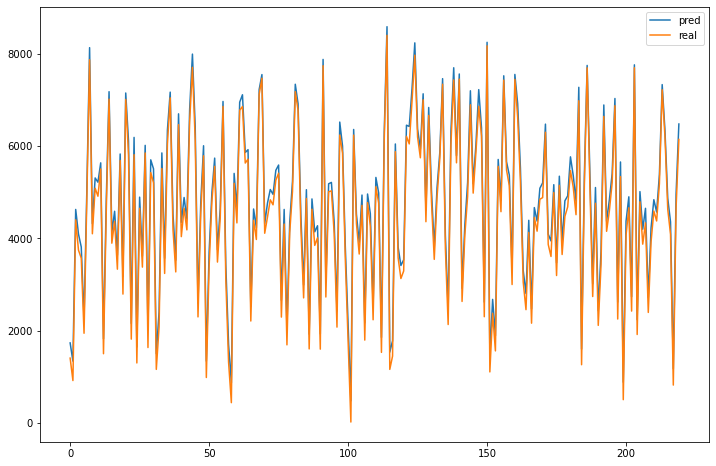

In [39]:
#Метод ridge cv
train_validate_report(ridge_cv,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])